In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv('carbon_dots.csv',encoding='latin1')
df.head(3)

,PlantName,part,Family,Extraction Solvent,Particle size,Zeta potential,Normal cells (N)/cancer cells ? C?,Human(H)/Animal(A) cells,Cell Lines,Cell viability Assay,Exposure Dose,% of cell viability,Exposure time
0,Alcea,leaf,Malvaceae,aqueous,3,-17.8,C,H,4T1,MTT,20.0,66.9,12
1,Alcea,leaf,Malvaceae,aqueous,3,-17.8,C,H,4T1,MTT,40.0,39.5,12
2,Alcea,leaf,Malvaceae,aqueous,3,-17.8,C,H,4T1,MTT,60.0,16.4,12


In [2]:
df.rename(columns={
    'Normal  cells (N)/cancer cells ? C?': 'CellType',
    'Human(H)/Animal(A) cells': 'Species'
}, inplace=True)
df.head(3)

,PlantName,part,Family,Extraction Solvent,Particle size,Zeta potential,CellType,Species,Cell Lines,Cell viability Assay,Exposure Dose,% of cell viability,Exposure time
0,Alcea,leaf,Malvaceae,aqueous,3,-17.8,C,H,4T1,MTT,20.0,66.9,12
1,Alcea,leaf,Malvaceae,aqueous,3,-17.8,C,H,4T1,MTT,40.0,39.5,12
2,Alcea,leaf,Malvaceae,aqueous,3,-17.8,C,H,4T1,MTT,60.0,16.4,12


In [3]:
from sklearn.linear_model import LinearRegression
df['Particle size'] = df['Particle size'].astype(str).str.replace('nm', '', regex=False).str.strip()
df['Particle size'] = pd.to_numeric(df['Particle size'], errors='coerce')
df['Zeta potential'] = df['Zeta potential'].astype(str).str.replace('mV', '', regex=False).str.strip()
df['Zeta potential'] = pd.to_numeric(df['Zeta potential'], errors='coerce')

train_data = df[df['Zeta potential'].notnull()]
missing_data = df[df['Zeta potential'].isnull()]

features = ['Particle size', 'Exposure Dose', 'Exposure time']

reg = LinearRegression()
reg.fit(train_data[features], train_data['Zeta potential'])

predicted = reg.predict(missing_data[features])
df.loc[df['Zeta potential'].isnull(), 'Zeta potential'] = predicted

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PlantName             207 non-null    object 
 1   part                  121 non-null    object 
 2   Family                207 non-null    object 
 3   Extraction Solvent    207 non-null    object 
 4   Particle size         207 non-null    float64
 5   Zeta potential        207 non-null    float64
 6   CellType              207 non-null    object 
 7   Species               207 non-null    object 
 8   Cell  Lines           207 non-null    object 
 9   Cell viability Assay  207 non-null    object 
 10  Exposure Dose         207 non-null    float64
 11  % of cell viability   207 non-null    float64
 12  Exposure time         207 non-null    int64  
dtypes: float64(4), int64(1), object(8)
memory usage: 21.2+ KB


In [4]:
numerical_cols = ['Particle size', 'Exposure Dose', 'Zeta potential', 'Exposure time']
df['Viability_Class'] = df['% of cell viability'].apply(lambda x: 1 if x > 50 else 0)
df.head(3)

,PlantName,part,Family,Extraction Solvent,Particle size,Zeta potential,CellType,Species,Cell Lines,Cell viability Assay,Exposure Dose,% of cell viability,Exposure time,Viability_Class
0,Alcea,leaf,Malvaceae,aqueous,3.0,-17.8,C,H,4T1,MTT,20.0,66.9,12,1
1,Alcea,leaf,Malvaceae,aqueous,3.0,-17.8,C,H,4T1,MTT,40.0,39.5,12,0
2,Alcea,leaf,Malvaceae,aqueous,3.0,-17.8,C,H,4T1,MTT,60.0,16.4,12,0


In [5]:
features = ['Particle size', 'Extraction Solvent', 'Exposure Dose', 'Zeta potential',
            'CellType', 'Species', 'Exposure time']
target = 'Viability_Class'

X = df[features]
y = df[target]

In [6]:
from sklearn.preprocessing import OneHotEncoder
categorical_cols = ['Extraction Solvent', 'CellType', 'Species']
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_encoded = encoder.fit_transform(X[categorical_cols])
X_final = pd.concat([
    pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_cols), index=X.index),
    X.drop(columns=categorical_cols).reset_index(drop=True)
], axis=1)
X_final.head(3)

,Extraction Solvent_aqueous,Extraction Solvent_organic,CellType_N,Species_H,Particle size,Exposure Dose,Zeta potential,Exposure time
0,1.0,0.0,0.0,1.0,3.0,20.0,-17.8,12
1,1.0,0.0,0.0,1.0,3.0,40.0,-17.8,12
2,1.0,0.0,0.0,1.0,3.0,60.0,-17.8,12


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [26]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(min_samples_split=10,random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

In [27]:
from sklearn.metrics import accuracy_score, classification_report,precision_score, recall_score, f1_score, roc_auc_score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.86      0.71         7
           1       0.97      0.89      0.93        35

    accuracy                           0.88        42
   macro avg       0.78      0.87      0.82        42
weighted avg       0.91      0.88      0.89        42



In [28]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_proba))

Accuracy: 0.8809523809523809
Precision: 0.96875
Recall: 0.8857142857142857
F1 Score: 0.9253731343283582
AUC Score: 0.8632653061224489


In [30]:
min_samples_splits = list(range(2, 21))
accuracies = []

for min_split in min_samples_splits:
    clf = RandomForestClassifier(min_samples_split=min_split, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"min_samples_split: {min_split}, Accuracy: {acc:.4f}")

min_samples_split: 2, Accuracy: 0.8095
min_samples_split: 3, Accuracy: 0.8095
min_samples_split: 4, Accuracy: 0.8810
min_samples_split: 5, Accuracy: 0.8571
min_samples_split: 6, Accuracy: 0.8810
min_samples_split: 7, Accuracy: 0.8810
min_samples_split: 8, Accuracy: 0.8810
min_samples_split: 9, Accuracy: 0.8810
min_samples_split: 10, Accuracy: 0.8810
min_samples_split: 11, Accuracy: 0.8810
min_samples_split: 12, Accuracy: 0.8571
min_samples_split: 13, Accuracy: 0.8571
min_samples_split: 14, Accuracy: 0.8571
min_samples_split: 15, Accuracy: 0.8571
min_samples_split: 16, Accuracy: 0.8571
min_samples_split: 17, Accuracy: 0.8571
min_samples_split: 18, Accuracy: 0.8571
min_samples_split: 19, Accuracy: 0.8571
min_samples_split: 20, Accuracy: 0.8571


Depth: 1, Accuracy: 0.8333
Depth: 2, Accuracy: 0.8333
Depth: 3, Accuracy: 0.8333
Depth: 4, Accuracy: 0.8571
Depth: 5, Accuracy: 0.8571
Depth: 6, Accuracy: 0.8810
Depth: 7, Accuracy: 0.8810
Depth: 8, Accuracy: 0.8810
Depth: 9, Accuracy: 0.8810
Depth: 10, Accuracy: 0.8810
Depth: 11, Accuracy: 0.8810
Depth: 12, Accuracy: 0.8810
Depth: 13, Accuracy: 0.8810
Depth: 14, Accuracy: 0.8810
Depth: 15, Accuracy: 0.8810
Depth: 16, Accuracy: 0.8810
Depth: 17, Accuracy: 0.8810
Depth: 18, Accuracy: 0.8810
Depth: 19, Accuracy: 0.8810
Depth: 20, Accuracy: 0.8810


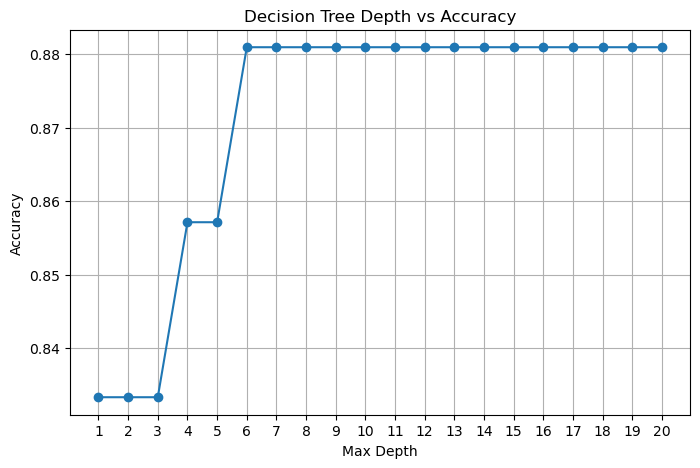

In [29]:
depths = list(range(1, 21)) 
accuracies = []

for depth in depths:
    clf = RandomForestClassifier(min_samples_split=10,max_depth=depth, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Depth: {depth}, Accuracy: {acc:.4f}")

plt.figure(figsize=(8,5))
plt.plot(depths, accuracies, marker='o')
plt.title('Decision Tree Depth vs Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.xticks(depths)
plt.grid(True)
plt.show()

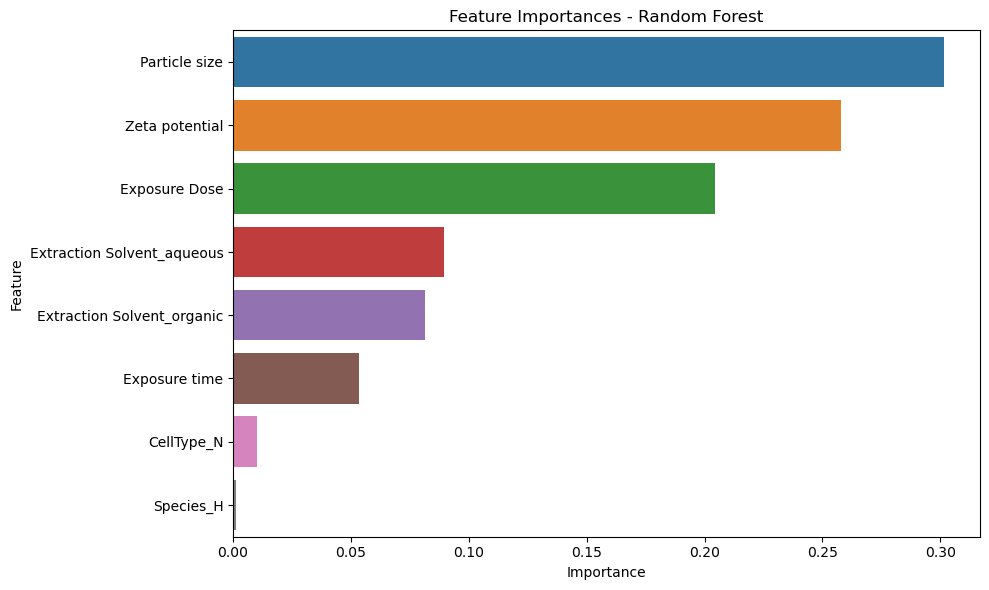

In [33]:
import numpy as np
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

feature_names = np.array(X_final.columns)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=feature_names[indices])
plt.title("Feature Importances - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [34]:
from sklearn.model_selection import cross_val_score
clf = RandomForestClassifier(min_samples_split=10,random_state=42)

cv_scores = cross_val_score(clf, X_final, y, cv=10, scoring='accuracy')
for i, score in enumerate(cv_scores, 1):
    print(f"Fold {i} Accuracy: {score:.4f}")

print(f"\nAverage Accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation: {np.std(cv_scores):.4f}")

Fold 1 Accuracy: 0.6190
Fold 2 Accuracy: 0.8095
Fold 3 Accuracy: 0.8095
Fold 4 Accuracy: 0.7619
Fold 5 Accuracy: 0.8571
Fold 6 Accuracy: 0.9524
Fold 7 Accuracy: 0.8571
Fold 8 Accuracy: 0.6000
Fold 9 Accuracy: 0.8500
Fold 10 Accuracy: 0.8000

Average Accuracy: 0.7917
Standard Deviation: 0.1029


Confusion Matrix:
 [[ 5  2]
 [ 4 31]]


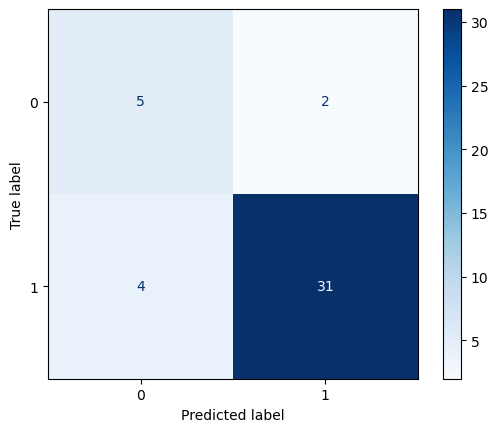

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()